Import dependencies

In [7]:
import sklearn
import pandas
from src.backend.resume_parser import custom_resume_parser
from src.backend.resume_parser.main import parse_dataset_to_csv
from sklearn.feature_extraction.text \
    import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

Datasets stored on csv files after being parsed

In [4]:
software_data = pandas.read_csv('dataset_csvs/software_dev.csv').fillna(' ')
software_features = software_data[['skills', 'experience', 'education_section']]
Y_sw = software_data['label']

Transform data to format usable by sklearn's models (Vectorize)

In [3]:
pipe = Pipeline([
    ('transform', ColumnTransformer([
        ('skills', CountVectorizer(), 'skills'),
        ('experience', TfidfVectorizer(), 'experience'),
        ('education', TfidfVectorizer(), 'education_section'),
    ])),
    ('logistic', LogisticRegression()),
])

Split data for testing and training

In [4]:
x_train_sw, x_test_sw, y_train_sw, y_test_sw = train_test_split(software_features,
                                                    Y_sw,
                                                    stratify=Y_sw,
                                                    random_state=20)

Find best parameters for LogisticRegression with GridSearch cross-validation

In [11]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'logistic__penalty': ['l2'],
    'logistic__C': pandas.np.logspace(-4, 4, 20),
    'logistic__solver': ['liblinear']
}

def grid_search(dataset_x, dataset_y):
    pipeline = Pipeline([
        ('transform', ColumnTransformer([
            ('skills', CountVectorizer(), 'skills'),
            ('experience', TfidfVectorizer(), 'experience'),
            ('education', TfidfVectorizer(), 'education_section'),
        ])),
        ('logistic', LogisticRegression()),
    ])
    cv = GridSearchCV(pipeline, param_grid, cv=5, verbose=True)
    cv.fit(dataset_x, dataset_y)
    return cv

def grid_search_noedu(dataset_x, dataset_y):
    pipeline = Pipeline([
        ('transform', ColumnTransformer([
            ('skills', CountVectorizer(), 'skills'),
            ('experience', TfidfVectorizer(), 'experience'),
        ])),
        ('logistic', LogisticRegression()),
    ])
    cv = GridSearchCV(pipeline, param_grid, cv=5, verbose=True)
    cv.fit(dataset_x, dataset_y)
    return cv


In [6]:
log_reg_cv = grid_search(software_features, Y_sw)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.1s finished


In [7]:
import os

os.getcwd()

'C:\\Users\\Eduardo Perez\\WebstormProjects\\RecruitingApp\\src\\backend\\resume_parser'

In [8]:
import joblib

joblib.dump(log_reg_cv.best_estimator_, '../ranking_models/sw_model.pkl')


['../ranking_models/sw_model.pkl']

In [7]:
print(log_reg_cv.best_params_)
print(log_reg_cv.best_score_)
log_reg_cv.cv_results_

{'logistic__C': 0.08858667904100823, 'logistic__penalty': 'l2', 'logistic__solver': 'liblinear'}
0.9111111111111111


{'mean_fit_time': array([0.04157338, 0.04041123, 0.03960013, 0.03965211, 0.03958616,
        0.04000406, 0.0406033 , 0.04060068, 0.04000044, 0.0417995 ,
        0.0415997 , 0.04132218, 0.04179983, 0.04179969, 0.04160004,
        0.04160004, 0.0413713 , 0.04140015, 0.04139915, 0.04160032]),
 'std_fit_time': array([0.00379296, 0.00344935, 0.00313711, 0.00287154, 0.00271378,
        0.00303765, 0.00360906, 0.00320073, 0.00303298, 0.0036554 ,
        0.0027281 , 0.00268328, 0.00278604, 0.00299335, 0.00307276,
        0.00265353, 0.00255965, 0.00338347, 0.00287047, 0.0032005 ]),
 'mean_score_time': array([0.01059971, 0.00959997, 0.00939965, 0.00899982, 0.00921893,
        0.0094008 , 0.00940104, 0.00919933, 0.00959973, 0.00940037,
        0.00899997, 0.00939999, 0.0095993 , 0.00939989, 0.00960035,
        0.00899987, 0.00940027, 0.00880036, 0.00960016, 0.00919943]),
 'std_score_time': array([0.00512306, 0.00300734, 0.00320032, 0.00252627, 0.00246728,
        0.00272946, 0.00233243, 0.002399

In [8]:
sw_best_model = log_reg_cv.best_estimator_
sw_best_model.fit(x_train_sw, y_train_sw)

sw_predictions = sw_best_model.predict(x_test_sw)
sw_score = sw_best_model.score(x_test_sw, y_test_sw)
sw_best_model.predict_proba(x_test_sw)

array([[0.13141966, 0.86858034],
       [0.66461341, 0.33538659],
       [0.75149105, 0.24850895],
       [0.49822842, 0.50177158],
       [0.67619729, 0.32380271],
       [0.50062921, 0.49937079],
       [0.92512626, 0.07487374],
       [0.00874292, 0.99125708],
       [0.69204995, 0.30795005],
       [0.46876838, 0.53123162],
       [0.61183312, 0.38816688]])

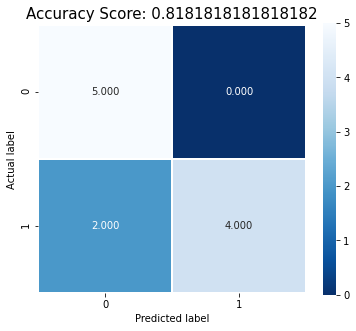

In [9]:
cm = metrics.confusion_matrix(y_test_sw, sw_predictions)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(sw_score)
plt.title(all_sample_title, size = 15);

Load software dev data where education isn't considered

In [10]:
sw_noedu_data = pandas.read_csv('dataset_csvs/software_dev_no_edu.csv').fillna('no info')
sw_noedu_features = sw_noedu_data[['skills', 'experience',]]
Y_sw_noedu = sw_noedu_data['label']

In [11]:
sw_noedu_cv = grid_search_noedu(sw_noedu_features, Y_sw_noedu)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.0s finished


In [12]:
print(sw_noedu_cv.best_params_)
print(sw_noedu_cv.best_score_)
sw_noedu_cv.cv_results_

{'logistic__C': 11.288378916846883, 'logistic__penalty': 'l2', 'logistic__solver': 'liblinear'}
0.8872727272727273


{'mean_fit_time': array([0.05626125, 0.05359979, 0.04640298, 0.04659953, 0.0465323 ,
        0.04680171, 0.04760103, 0.0473999 , 0.04799967, 0.04759979,
        0.04799976, 0.0486002 , 0.0486001 , 0.048703  , 0.04968863,
        0.04857368, 0.04900126, 0.04939938, 0.04939985, 0.04900022]),
 'std_fit_time': array([0.0155931 , 0.00659121, 0.00344112, 0.00313687, 0.00329711,
        0.00343223, 0.00332077, 0.0032625 , 0.0033472 , 0.00293876,
        0.00334658, 0.00332264, 0.00372003, 0.00337193, 0.00335854,
        0.00376338, 0.00303383, 0.00361168, 0.00377381, 0.00334667]),
 'mean_score_time': array([0.0112011 , 0.01220107, 0.01079907, 0.0110002 , 0.0107995 ,
        0.0105998 , 0.01099987, 0.01060004, 0.01060038, 0.0110003 ,
        0.01100006, 0.01079955, 0.01079936, 0.0108017 , 0.01140032,
        0.01099963, 0.01139908, 0.0106009 , 0.01100044, 0.01120052]),
 'std_score_time': array([0.00285697, 0.00491533, 0.00292522, 0.00275581, 0.00271316,
        0.00300637, 0.00275566, 0.003006

In [17]:
from sklearn.base import clone

def show_predict_proba_and_cm(x, y, model):
    x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                        stratify=y, random_state=20)
    classifier = clone(model)
    classifier.fit(x_train, y_train)
    predictions = classifier.predict(x_test)
    score = classifier.score(x_test, y_test)
    print(classifier.predict_proba(x_test))

    cm_graph = metrics.confusion_matrix(y_test, predictions)

    plt.figure(figsize=(6,5))
    sns.heatmap(cm_graph, annot=True, fmt=".3f", linewidths=.5,
                square = True, cmap = 'Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    title = 'Accuracy Score: {0}'.format(score)
    plt.title(title, size = 15)

[[8.62883013e-01 1.37116987e-01]
 [3.99750041e-01 6.00249959e-01]
 [9.43656063e-01 5.63439372e-02]
 [6.28050661e-05 9.99937195e-01]
 [8.99768001e-01 1.00231999e-01]
 [9.88928732e-01 1.10712677e-02]
 [2.49727749e-05 9.99975027e-01]
 [1.07906306e-02 9.89209369e-01]
 [8.69336859e-06 9.99991307e-01]
 [9.01210307e-06 9.99990988e-01]
 [7.56525794e-01 2.43474206e-01]
 [9.30942975e-01 6.90570245e-02]
 [9.99607193e-01 3.92807452e-04]]


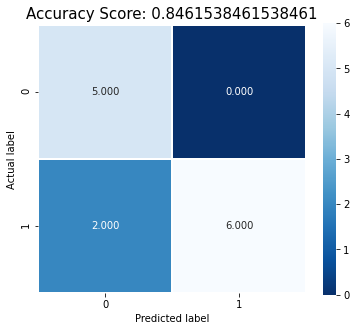

In [14]:
show_predict_proba_and_cm(sw_noedu_features, Y_sw_noedu,
                          sw_noedu_cv.best_estimator_)

Load data for other models

In [15]:
parsed_resumes = pandas.read_csv(
    "parsed_results_dec3_v4.csv", encoding="utf-8"
)[["education_section", "experience_section", "designation", "resume"]]

In [5]:
accounting_resumes = pandas.read_csv(
    "dataset_csvs/accounting.csv", encoding="utf-8"
)[["skills", "experience", "education_section", "label", "resume"]]

accounting_no_edu_resumes = pandas.read_csv(
    "dataset_csvs/accounting_no_edu.csv", encoding="utf-8"
)[["skills", "experience", "education_section", "label", "resume"]]

In [12]:
mgmt_resumes = pandas.read_csv(
    "dataset_csvs/management.csv", encoding="utf-8"
)[["skills", "experience", "education_section", "label", "resume"]]

mgmt_no_edu_resumes = pandas.read_csv(
    "dataset_csvs/management_no_edu.csv", encoding="utf-8"
)[["skills", "experience", "education_section", "label", "resume"]]

Management model training and results

In [13]:
mgmt_features = mgmt_resumes[["skills", "experience", "education_section"]].fillna('no info')
mgmt_y = mgmt_resumes["label"]

mgmt_no_edu_features = mgmt_no_edu_resumes[["skills", "experience", "education_section"]].fillna('no info')
mgmt_no_edu_y = mgmt_no_edu_resumes["label"]

In [14]:
mgmt_cv = grid_search(mgmt_features, mgmt_y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.0s finished


In [23]:
mgmt_cv.best_params_

{'logistic__C': 0.615848211066026,
 'logistic__penalty': 'l2',
 'logistic__solver': 'liblinear'}

In [23]:
mgmt_cv.best_score_

0.7916666666666667

In [15]:
mgmt_no_edu_cv = grid_search_noedu(mgmt_no_edu_features, mgmt_no_edu_y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.6s finished


In [25]:
mgmt_no_edu_cv.best_params_

{'logistic__C': 0.08858667904100823,
 'logistic__penalty': 'l2',
 'logistic__solver': 'liblinear'}

In [24]:
mgmt_no_edu_cv.best_score_

0.836111111111111

Management (With edu) results

[[0.11576528 0.88423472]
 [0.912617   0.087383  ]
 [0.33964914 0.66035086]
 [0.73109363 0.26890637]
 [0.77192263 0.22807737]
 [0.18009546 0.81990454]
 [0.66209608 0.33790392]
 [0.25526146 0.74473854]
 [0.58986193 0.41013807]
 [0.53047139 0.46952861]
 [0.80784615 0.19215385]]


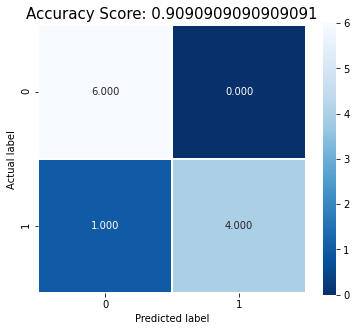

In [18]:
show_predict_proba_and_cm(mgmt_features, mgmt_y, mgmt_cv.best_estimator_)

Management (No edu) results

[[0.15523995 0.84476005]
 [0.7576383  0.2423617 ]
 [0.08829244 0.91170756]
 [0.38719045 0.61280955]
 [0.43727881 0.56272119]
 [0.12805384 0.87194616]
 [0.9390416  0.0609584 ]
 [0.12644332 0.87355668]
 [0.84466406 0.15533594]
 [0.12294808 0.87705192]
 [0.75001942 0.24998058]]


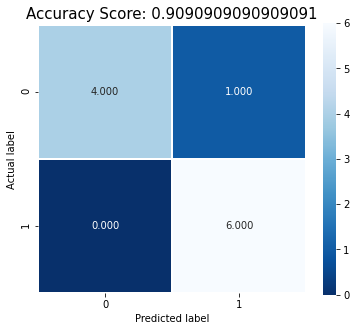

In [19]:
show_predict_proba_and_cm(mgmt_no_edu_features, mgmt_no_edu_y, mgmt_no_edu_cv.best_estimator_)

Accounting model training

In [26]:
account_features = accounting_resumes[["skills", "experience", "education_section"]].fillna('no info')
account_y = accounting_resumes["label"]

account_no_edu_features = accounting_no_edu_resumes[["skills", "experience", "education_section"]].fillna('no info')
account_no_edu_y = accounting_no_edu_resumes["label"]

In [27]:
account_cv = grid_search(account_features, account_y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.8s finished


In [28]:
account_cv.best_params_

{'logistic__C': 1.623776739188721,
 'logistic__penalty': 'l2',
 'logistic__solver': 'liblinear'}

In [29]:
account_cv.best_score_

0.9444444444444444

In [31]:
account_no_edu_cv = grid_search_noedu(account_no_edu_features, account_no_edu_y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    7.5s finished


In [32]:
account_no_edu_cv.best_params_

{'logistic__C': 0.615848211066026,
 'logistic__penalty': 'l2',
 'logistic__solver': 'liblinear'}

In [33]:
account_no_edu_cv.best_score_

0.9777777777777779

Accounting (With edu) results

[[1.02302724e-02 9.89769728e-01]
 [9.99770137e-01 2.29862726e-04]
 [7.94381066e-01 2.05618934e-01]
 [9.85488034e-01 1.45119664e-02]
 [1.28830067e-02 9.87116993e-01]
 [9.99274070e-01 7.25930277e-04]
 [6.96371166e-02 9.30362883e-01]
 [2.83265478e-01 7.16734522e-01]
 [9.99994396e-01 5.60368656e-06]
 [1.14011171e-01 8.85988829e-01]
 [6.84356543e-02 9.31564346e-01]
 [9.86686005e-01 1.33139948e-02]
 [2.23909163e-02 9.77609084e-01]
 [8.66947044e-01 1.33052956e-01]
 [4.32986785e-02 9.56701322e-01]
 [9.98808508e-01 1.19149238e-03]
 [1.71005443e-01 8.28994557e-01]
 [6.65187404e-03 9.93348126e-01]
 [2.73778190e-02 9.72622181e-01]
 [2.82790055e-01 7.17209945e-01]
 [3.09940252e-01 6.90059748e-01]
 [9.66905134e-01 3.30948660e-02]]


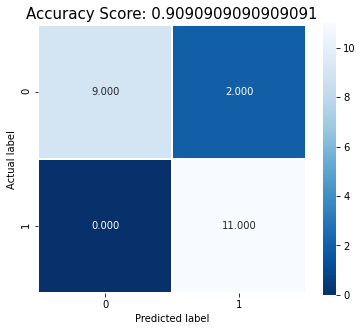

In [33]:
show_predict_proba_and_cm(account_features, account_y, account_cv.best_estimator_)

Accounting (Without edu) results

[[1.33066179e-01 8.66933821e-01]
 [7.66551432e-01 2.33448568e-01]
 [3.67890150e-02 9.63210985e-01]
 [1.57235824e-01 8.42764176e-01]
 [9.79906252e-02 9.02009375e-01]
 [8.76612544e-01 1.23387456e-01]
 [1.51244601e-01 8.48755399e-01]
 [5.18684581e-02 9.48131542e-01]
 [9.99813360e-01 1.86639521e-04]
 [9.47586403e-01 5.24135973e-02]
 [4.89820898e-02 9.51017910e-01]
 [9.89185529e-01 1.08144708e-02]
 [1.27837526e-01 8.72162474e-01]
 [8.83943608e-01 1.16056392e-01]
 [3.37419476e-03 9.96625805e-01]
 [9.50812468e-01 4.91875320e-02]
 [4.06261702e-02 9.59373830e-01]
 [9.58159871e-02 9.04184013e-01]
 [2.32261220e-02 9.76773878e-01]
 [6.12322152e-02 9.38767785e-01]
 [9.93812835e-01 6.18716489e-03]
 [9.99661279e-01 3.38721317e-04]]


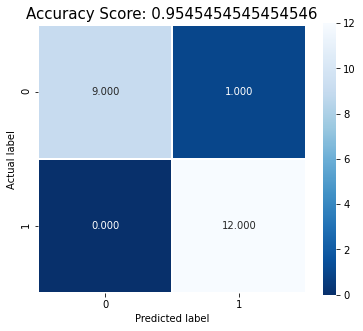

In [34]:
show_predict_proba_and_cm(account_no_edu_features, account_no_edu_y, account_no_edu_cv.best_estimator_)

Dump model to disk to use in backend

In [22]:
import joblib

joblib.dump(mgmt_cv.best_estimator_, '../ranking_models/mgmt_model.pkl')

['../ranking_models/mgmt_model.pkl']

roc curves

In [39]:
from sklearn.metrics import plot_roc_curve

def generate_roc_curve(x, y, estimator):
    X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42)
    estimator.fit(X_train, y_train)

    plot_roc_curve(estimator, X_test, y_test)


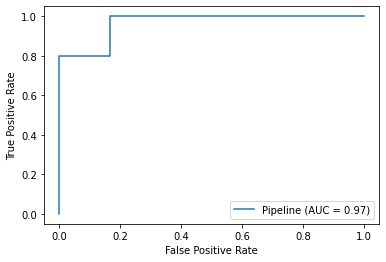

In [42]:
generate_roc_curve(software_features, Y_sw, mgmt_cv.best_estimator_)